## Setup

In [ ]:
!pip install fastai2

from fastai2.vision.all import *
from fastai2.vision.widgets import *

## Bing Image Search API (you can skip this part)

To use Bing Image Search API, you should sign up at Microsoft for *Bing Image Search*. You will be given a key, which you should paste here, replacing "XXX":

In [ ]:
key = 'XXX'

In [ ]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

# copied from the course materials (utils.py)
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [ ]:
results = search_images_bing(key, 'normal histology kidney')
ims = results.attrgot('content_url')
len(ims)

150

In [ ]:
ims[1]

'http://www.proteinatlas.org/images_dictionary/kidney__1__example_1__1_25.jpg'

In [ ]:
tissue_types = 'kidney', 'liver', 'spleen'
path = Path('histology')

url_images = {}

for o in tissue_types:
  results = search_images_bing(key, f'normal {o} histology')
  url_images[o] = results.attrgot('content_url')

url_images_df = pd.DataFrame(url_images)

## Downloading images

In [ ]:
tissue_types = 'kidney', 'liver', 'spleen'
path = Path('histology')

!rm -rf histology
# to run without Bing Search API
url_images_df = pd.read_csv('https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/data/histology.csv')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in tissue_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        download_images(dest, urls=url_images_df[o])

In [ ]:
fns = get_image_files(path)
fns

(#446) [Path('histology/liver/00000146.jpg'),Path('histology/liver/00000122.png'),Path('histology/liver/00000008.png'),Path('histology/liver/00000007.jpeg'),Path('histology/liver/00000136.jpg'),Path('histology/liver/00000107.jpg'),Path('histology/liver/00000147.jpg'),Path('histology/liver/00000124.jpg'),Path('histology/liver/00000149.jpg'),Path('histology/liver/00000096.jpg')...]

In [ ]:
# failed downloads
failed = verify_images(fns)
failed

(#101) [Path('histology/liver/00000008.png'),Path('histology/liver/00000107.jpg'),Path('histology/liver/00000147.jpg'),Path('histology/liver/00000096.jpg'),Path('histology/liver/00000027.png'),Path('histology/liver/00000058.png'),Path('histology/liver/00000127.png'),Path('histology/liver/00000059.png'),Path('histology/liver/00000069.png'),Path('histology/liver/00000022.png')...]

In [ ]:
failed.map(Path.unlink);

## From data to DataLoaders

In [ ]:
cells = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = cells.dataloaders(path)

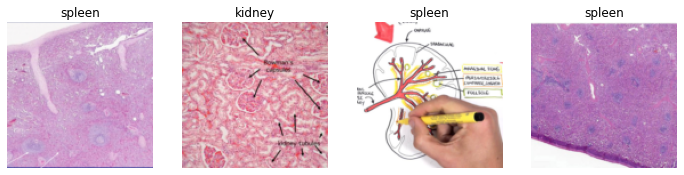

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

### Data augmentation

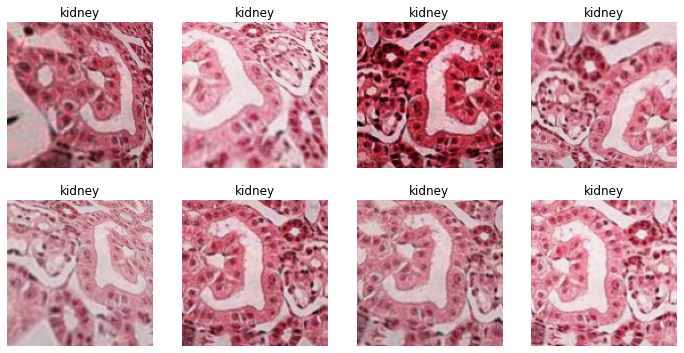

In [ ]:
cells = cells.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cells.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

## Model Training

In [ ]:
cells = cells.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cells.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.852042,1.533467,0.582524,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.374498,1.278638,0.524272,00:05
1,1.113321,1.272588,0.407767,00:05
2,1.045737,1.275510,0.359223,00:05
3,0.944620,1.223596,0.349515,00:05


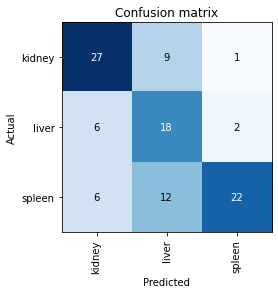

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

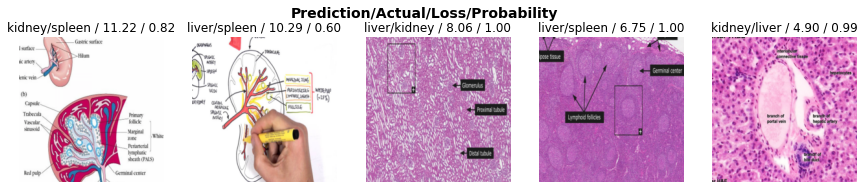

In [ ]:
interp.plot_top_losses(5, nrows=1)

## Predict a new sample

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving IMG_20200827_222414.jpg to IMG_20200827_222414.jpg


In [ ]:
img = PILImage.create(list(uploaded.values())[0])

In [ ]:
pred,pred_idx,probs = learn.predict(img)
pred,pred_idx,probs

('liver', tensor(1), tensor([0.0154, 0.8915, 0.0931]))